In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

np.random.seed(42)
# Take in the dataset
dataset = pd.read_csv('mxmh_survey_results.csv')
dataset

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,10/30/2022 14:37:28,17.0,Spotify,2.0,Yes,Yes,No,Rock,Yes,Yes,...,Never,Rarely,Very frequently,Never,7.0,6.0,0.0,9.0,Improve,I understand.
732,11/1/2022 22:26:42,18.0,Spotify,1.0,Yes,Yes,No,Pop,Yes,Yes,...,Never,Never,Sometimes,Sometimes,3.0,2.0,2.0,5.0,Improve,I understand.
733,11/3/2022 23:24:38,19.0,Other streaming service,6.0,Yes,No,Yes,Rap,Yes,No,...,Sometimes,Sometimes,Rarely,Rarely,2.0,2.0,2.0,2.0,Improve,I understand.
734,11/4/2022 17:31:47,19.0,Spotify,5.0,Yes,Yes,No,Classical,No,No,...,Never,Never,Never,Sometimes,2.0,3.0,2.0,1.0,Improve,I understand.


In [2]:
# Drop unnecessary columns
drop_columns = ['Permissions', 'While working', 'Timestamp', 'Instrumentalist', 'Composer', 'Exploratory']
dataset = dataset.drop(columns=drop_columns)
dataset

,Age,Primary streaming service,Hours per day,Fav genre,Foreign languages,BPM,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
0,18.0,Spotify,3.0,Latin,Yes,156.0,Rarely,Never,Rarely,Never,...,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN
1,63.0,Pandora,1.5,Rock,No,119.0,Sometimes,Never,Never,Rarely,...,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN
2,18.0,Spotify,4.0,Video game music,Yes,132.0,Never,Never,Very frequently,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect
3,61.0,YouTube Music,2.5,Jazz,Yes,84.0,Sometimes,Never,Never,Rarely,...,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve
4,18.0,Spotify,4.0,R&B,No,107.0,Never,Never,Rarely,Never,...,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,17.0,Spotify,2.0,Rock,Yes,120.0,Very frequently,Rarely,Never,Sometimes,...,Very frequently,Never,Rarely,Very frequently,Never,7.0,6.0,0.0,9.0,Improve
732,18.0,Spotify,1.0,Pop,Yes,160.0,Rarely,Rarely,Never,Never,...,Very frequently,Never,Never,Sometimes,Sometimes,3.0,2.0,2.0,5.0,Improve
733,19.0,Other streaming service,6.0,Rap,No,120.0,Rarely,Sometimes,Sometimes,Rarely,...,Sometimes,Sometimes,Sometimes,Rarely,Rarely,2.0,2.0,2.0,2.0,Improve
734,19.0,Spotify,5.0,Classical,No,170.0,Very frequently,Never,Never,Never,...,Never,Never,Never,Never,Sometimes,2.0,3.0,2.0,1.0,Improve


In [3]:
# Handling outliers
z_scores = zscore(dataset['Age'])
outlier_indices = np.abs(z_scores) > 3
dataset = dataset[~outlier_indices]

z_scores = zscore(dataset['Hours per day'])
outlier_indices = np.abs(z_scores) > 3
dataset = dataset[~outlier_indices]

In [4]:
dataset.describe()

,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD
count,725.000000,726.000000,6.200000e+02,726.000000,726.000000,726.000000,726.000000
mean,25.124138,3.369904,1.613026e+06,5.839532,4.785124,3.708678,2.622590
std,11.830807,2.454285,4.016096e+07,2.788537,3.007113,3.068783,2.828205
min,10.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,1.000000e+02,4.000000,2.000000,1.000000,0.000000
50%,21.000000,3.000000,1.200000e+02,6.000000,5.000000,3.000000,2.000000
75%,28.000000,4.000000,1.440000e+02,8.000000,7.000000,6.000000,4.000000
max,80.000000,12.000000,1.000000e+09,10.000000,10.000000,10.000000,10.000000


In [5]:
def remove_outliers_iqr(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers using IQR method (InterQuartile Range)
dataset = remove_outliers_iqr(dataset, 'BPM')

In [6]:
# Adding a mental health score column
dataset["Mental health score"] = (dataset['Anxiety'] + dataset['Depression'] + dataset['OCD'] + dataset['Insomnia'])
# Convert continuous target variable(y) to discrete categories
bins = [0, 10, 20, 30, 40]
labels = ['Very low', 'Low', 'Moderate', 'High']
dataset['Mental health category'] = pd.cut(dataset['Mental health score'], bins=bins, labels=labels)
dataset

,Age,Primary streaming service,Hours per day,Fav genre,Foreign languages,BPM,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Mental health score,Mental health category
0,18.0,Spotify,3.0,Latin,Yes,156.0,Rarely,Never,Rarely,Never,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,4.0,Very low
1,63.0,Pandora,1.5,Rock,No,119.0,Sometimes,Never,Never,Rarely,...,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,12.0,Low
2,18.0,Spotify,4.0,Video game music,Yes,132.0,Never,Never,Very frequently,Never,...,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,26.0,Moderate
3,61.0,YouTube Music,2.5,Jazz,Yes,84.0,Sometimes,Never,Never,Rarely,...,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,22.0,Moderate
4,18.0,Spotify,4.0,R&B,No,107.0,Never,Never,Rarely,Never,...,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,23.0,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,17.0,Spotify,2.0,Rock,Yes,120.0,Very frequently,Rarely,Never,Sometimes,...,Rarely,Very frequently,Never,7.0,6.0,0.0,9.0,Improve,22.0,Moderate
732,18.0,Spotify,1.0,Pop,Yes,160.0,Rarely,Rarely,Never,Never,...,Never,Sometimes,Sometimes,3.0,2.0,2.0,5.0,Improve,12.0,Low
733,19.0,Other streaming service,6.0,Rap,No,120.0,Rarely,Sometimes,Sometimes,Rarely,...,Sometimes,Rarely,Rarely,2.0,2.0,2.0,2.0,Improve,8.0,Very low
734,19.0,Spotify,5.0,Classical,No,170.0,Very frequently,Never,Never,Never,...,Never,Never,Sometimes,2.0,3.0,2.0,1.0,Improve,8.0,Very low


In [7]:
# Convert categorical columns to one hot encoded columns
dataset_hot = pd.get_dummies(dataset)
# Define features and target
X = dataset_hot.drop('Mental health score', axis=1)
y = dataset_hot['Mental health score']

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

# Split the dataset into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.5, random_state=42)
# Splitting test set in half, one half remains in test set and the other goes to the validation set

# Defining preprocessing steps for numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
# Include columns with integers and floating point variables
categorical_features = X.select_dtypes(include=['object']).columns
# Include all other columns that contain 'objects'

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # SimpleImputer replaces all missing values with the median
    ('scaler', StandardScaler())])
    # StandardScaler makes each feature have a standard deviation of 1 and a mean of 0

    # NOTE: StandardScaler does not modify the data, it only transforms it to be easier to read by a Machine Learning model.
    # This means the data sent into the model is the exact same as the dataset, only its been standardized
    # More info on https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])
    # This instance of SimpleImputer replaces missing values with the one that appears most frequently

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Creating pipeline with preprocessing and classifier GaussianNB()
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GaussianNB())])

# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Hours per day', 'BPM', 'Anxiety', 'Depression', 'Insomnia',
       'OCD'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', GaussianNB())])

In [9]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy *= 100
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Testing Set Metrics:")
print("Accuracy: ", accuracy, "%", sep="")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Testing Set Metrics:
Accuracy: 38.81578947368421%
Mean Absolute Error (MAE): 1.5526315789473684
Mean Squared Error (MSE): 5.651315789473684
Root Mean Squared Error (RMSE): 2.377249627084561
R-squared (R2): 0.9269518489949571


In [10]:
# Make predictions on the validation set
y_pred_valid = pipeline.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
accuracy_valid *= 100
mae_valid = mean_absolute_error(y_valid, y_pred_valid)
mse_valid = mean_squared_error(y_valid, y_pred_valid)
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
r2_valid = r2_score(y_valid, y_pred_valid)

print("Validation Set Metrics:")
print("Accuracy: ", accuracy_valid, "%", sep="")
print("Mean Absolute Error (MAE):", mae_valid)
print("Mean Squared Error (MSE):", mse_valid)
print("Root Mean Squared Error (RMSE):", rmse_valid)
print("R-squared (R2):", r2_valid)

Validation Set Metrics:
Accuracy: 27.54098360655738%
Mean Absolute Error (MAE): 2.0491803278688523
Mean Squared Error (MSE): 8.514754098360656
Root Mean Squared Error (RMSE): 2.9180051573567614
R-squared (R2): 0.8815268060212624


In [11]:
X_test

,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,...,Frequency [Video game music]_Rarely,Frequency [Video game music]_Sometimes,Frequency [Video game music]_Very frequently,Music effects_Improve,Music effects_No effect,Music effects_Worsen,Mental health category_Very low,Mental health category_Low,Mental health category_Moderate,Mental health category_High
598,17.0,12.0,172.0,0.0,3.0,9.0,5.0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
711,19.0,5.0,210.0,8.0,6.0,7.0,0.0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
628,15.0,4.0,140.0,10.0,7.0,3.0,2.0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
78,18.0,2.0,150.0,9.0,0.0,5.0,10.0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
447,24.0,2.0,93.0,7.0,7.0,0.0,4.0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,22.0,2.0,126.0,7.0,8.0,5.0,1.0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
119,28.0,0.5,130.0,4.0,7.0,1.0,0.0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
318,25.0,3.0,150.0,9.0,8.0,6.0,2.0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
521,20.0,8.0,93.0,7.0,6.0,7.0,4.0,0,0,0,...,1,0,0,1,0,0,0,0,1,0


In [12]:
print(y_test)

[17 22 23 25 18 28 27 24  6 21  6 10 17 33 12 15 21 37 27 34 11  6 16  6
 26 11 27  4 17  2 22 23 16 25 19 34 26 22  7  6  2 19  9 31 16  7 17 16
 22 12 25 10 16 13 29 26  1  4 22 14 10 13 15 13 18 12  8 10 18 15 18  9
  4  9 27 13 10  6 10 18 27 22 32  3  9 19 19 22 11 18 13 10 12 14  6 17
 17 27 25 23 14 27 29  1 19 21 32  7  3 21 15  1  5  1 22 31  8 23 12 23
 24  5 11 17 27  9 19  5 31  7 13  4 28 34  0 34 24  2  0 22 18 22 23  5
 10 28 27  5 26 26 12 21 11 30 17 15  0 18  2 18 11 16 14 22 23 11 21 18
 38 23  5 11 10 22 20 28 22 15 29  3 25 23 21 24 18 29 26 37 14 16 27 17
 27 16 29 26 21 11 13 19 11  9 23 24  4  8 23 14 21 18 31 10 31 21 28 14
 24  8 22 11 26  8 23 23 27 23 16 23 29  6 12 21 21 16  6  8 27 15  8 26
 25 29 17 10 27  0 12 28 18 11 18 24  8 25 18 14 23 18 25 24 17 29 19 32
 24  0 25  8 28  7 24  3 12  6 33  2 29 25 18 27  6 15 12 11 10  7  7 24
 19 31 23 25 21 11 24 29 29 27 36 22 12 26 25 26]


In [13]:
print(y_pred)

[17 22 18 28 18 28 27 27  6 19  8  7 10 33 14 15 10 37 27 34 11  7 12 11
 27 11 27  3 18  1 26 27 13 24 18 34 23 17  6  6  1 16  6 29 18  7 18 16
 22 16 25  8 15 15 26 24  1  4 22 13 10 15 15 11 23 17  8 11 16 15 18 11
  4  9 27 13 11  6  7 15 22 17 29  3 13 15 15 22  7 16 16 10 11 16  6 19
 18 27 27 24 14 23 29  1 24 18 34  7  1 23 15  1  5  1 22 31  8 24  8 24
 24  6 11 16 27 11 19  5 28  9 13  5 28 34  0 34 25  1  0 16 17 22 22  5
 11 29 29  6 27 29 14 21 11 30 18 12  0 18  6 16 11 16 15 18 24 11 18 18
 38 21  3  8 11 19 20 28 24 15 29  3 22 24 18 16 18 27 22 37 14 16 27 17
 23 16 28 27 18 16 16 19 11  9 24 28  4 13 24 11 18 18 31 13 23 18 29 17
 27  8 18 15 31 13 24 14 29 17 16 24 27  5 11 23 24 16  6 11 29 16  7 29
 27 27 18 15 27  0 10 28 18 15 18 29  6 24 15 15 24 16 27 24 18 29 18 32
 24  0 27 11 27  5 24  1 11  6 28  2 29 24 16 27  6 15 13 11 10  7  8 23
 19 35 24 29 22 11 27 28 29 24 36 24 11 29 27 27]


In [14]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
reg_model_diff

,Actual value,Predicted value
0,17,17
1,22,22
2,23,18
3,25,28
4,18,18
...,...,...
299,22,24
300,12,11
301,26,29
302,25,27


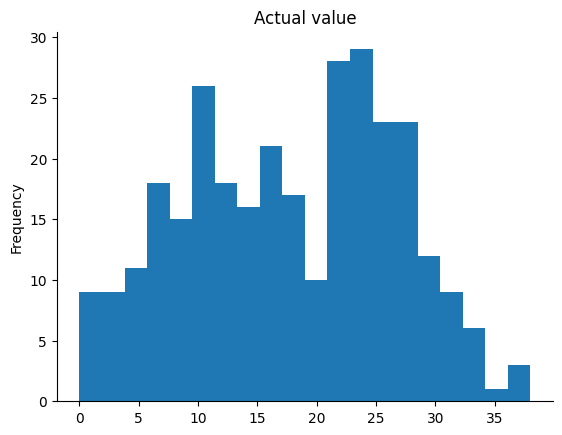

In [15]:
# @title Actual value

from matplotlib import pyplot as plt
reg_model_diff['Actual value'].plot(kind='hist', bins=20, title='Actual value')
plt.gca().spines[['top', 'right',]].set_visible(False)

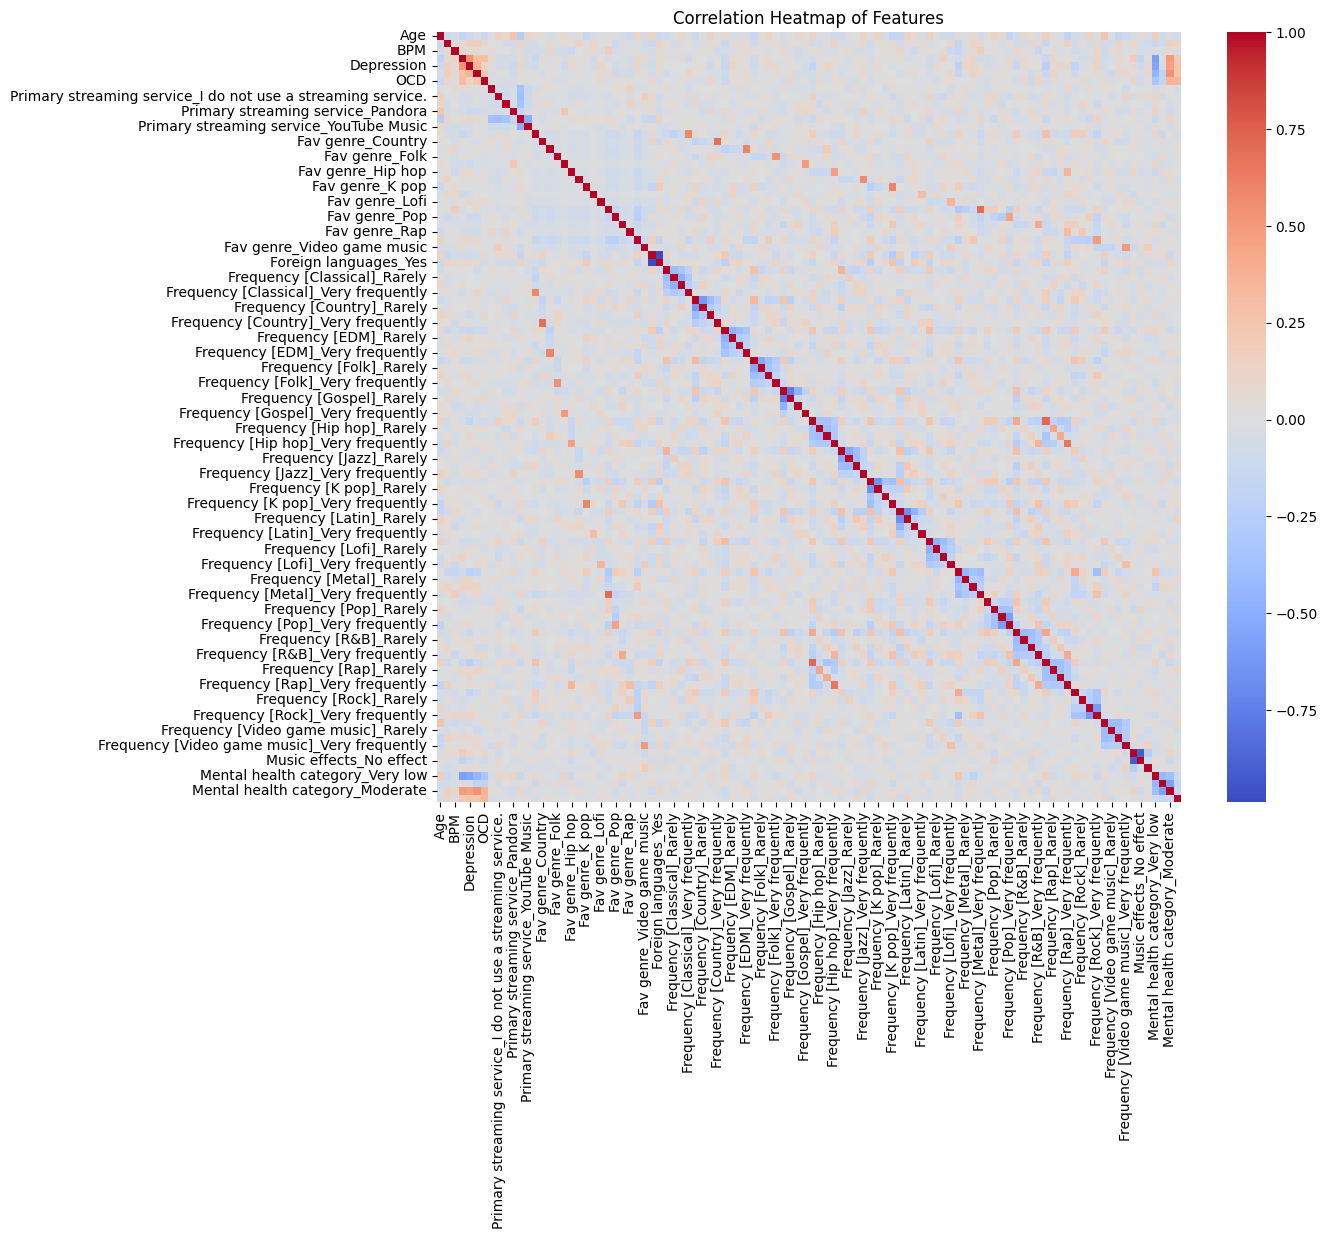

In [16]:
# Calculate the correlation matrix
correlation_matrix = X_train.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

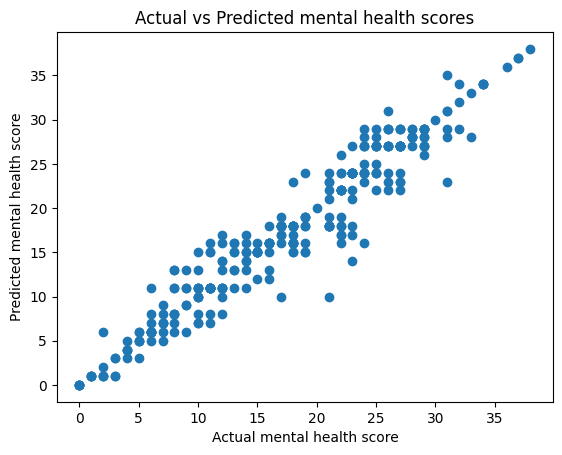

In [17]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual mental health score')
plt.ylabel("Predicted mental health score")
plt.title("Actual vs Predicted mental health scores")
plt.show()

In [20]:
# Filter dataset to include only columns about if a person likes a specific genre
filtered_columns = ['Fav genre_Country', 'Fav genre_Video game music', 'Fav genre_Metal', 'Fav genre_Pop',
                    'Fav genre_EDM', 'Fav genre_R&B', 'Fav genre_K pop', 'Fav genre_Hip hop',
                    'Fav genre_Classical', 'Fav genre_Folk', 'Fav genre_Gospel', 'Fav genre_Jazz',
                    'Fav genre_Latin', 'Fav genre_Lofi', 'Fav genre_Rap', 'Fav genre_Rock', ]
X_filtered = X_train[filtered_columns]

# Encode target variable into binary (low/high) labels
le = LabelEncoder()
y_binary = le.fit_transform(y_train)
# Low = 0, High = 1

# Calculate mutual information between filtered X and binary y
mutual_info = mutual_info_regression(X_filtered, y_binary)

# Creating a dictionary to store feature importance
feature_importance = dict(zip(X_filtered.columns, mutual_info))

# Sorting features based on mutual information (higher values = higher importance)
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Converting importance values into percentages
sorted_features_percentages = [(feature, importance * 100) for feature, importance in sorted_features]

# Printing sorted features with percentages
print("Favorite genres affecting Mental Health Score:")
for feature, importance_percentage in sorted_features_percentages:
    print(feature, f"{importance_percentage:.2f}%")


Favorite genres affecting Mental Health Score:
Fav genre_Rock 4.32%
Fav genre_R&B 4.27%
Fav genre_Folk 3.96%
Fav genre_Lofi 2.45%
Fav genre_Jazz 2.08%
Fav genre_Classical 1.04%
Fav genre_Hip hop 0.58%
Fav genre_K pop 0.11%
Fav genre_Country 0.00%
Fav genre_Video game music 0.00%
Fav genre_Metal 0.00%
Fav genre_Pop 0.00%
Fav genre_EDM 0.00%
Fav genre_Gospel 0.00%
Fav genre_Latin 0.00%
Fav genre_Rap 0.00%


In [19]:
# Concat. one-hot encoded genres with  mental health score
data_with_mental_health = pd.concat([dataset_hot, dataset['Mental health score']], axis=1)

# Create new column representing combination of favorite music genres
data_with_mental_health['Music Genre Combination'] = data_with_mental_health[filtered_columns].apply(lambda x: '_'.join(map(str, x)), axis=1)

# Making Favorite Genre column for readability
data_with_mental_health['Favorite Genre'] = data_with_mental_health[filtered_columns].idxmax(axis=1).str.replace('Fav genre_', '')

# Group by new column and calculate avg. mental health score
average_mental_health_score = data_with_mental_health.groupby(['Music Genre Combination', 'Favorite Genre'])['Mental health score'].mean().reset_index()

print("Average Mental Health Score for each Favorite Music Genre Combination:\n")
print(average_mental_health_score)

Average Mental Health Score for each Favorite Music Genre Combination:

            Music Genre Combination    Favorite Genre  Mental health score  \
0   0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1              Rock            18.185811   
1   0_0_0_0_0_0_0_0_0_0_0_0_0_0_1_0               Rap            14.722222   
2   0_0_0_0_0_0_0_0_0_0_0_0_0_1_0_0              Lofi            21.700000   
3   0_0_0_0_0_0_0_0_0_0_0_0_1_0_0_0             Latin            12.333333   
4   0_0_0_0_0_0_0_0_0_0_0_1_0_0_0_0              Jazz            16.777778   
5   0_0_0_0_0_0_0_0_0_0_1_0_0_0_0_0            Gospel            10.666667   
6   0_0_0_0_0_0_0_0_0_1_0_0_0_0_0_0              Folk            18.000000   
7   0_0_0_0_0_0_0_0_1_0_0_0_0_0_0_0         Classical            15.975000   
8   0_0_0_0_0_0_0_1_0_0_0_0_0_0_0_0           Hip hop            18.566667   
9   0_0_0_0_0_0_1_0_0_0_0_0_0_0_0_0             K pop            15.833333   
10  0_0_0_0_0_1_0_0_0_0_0_0_0_0_0_0               R&B            15.13